In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from vis_utils import plot_time_series
import numpy as np

In [2]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str,
                 response_type: str,
                 transform: transforms.Compose = trans,
                 train: bool= True):
        self.file_path = path
        # The available types are firing_rate_10ms, binned
        self.response_type = response_type
        self.X = None
        self.y = None
        self.transform = transform
        # Choose either train or test subsets
        self.data_type = "train" if train else "test"
        with File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.data_type]["stimulus"])

    def __getitem__(self, idx: int):
        if self.X is None or self.y is None:
            h5file = File(self.file_path, 'r')
            # Read as numpy array
            # TODO: see if there is a better way
            self.X = np.asarray(h5file[self.data_type]["stimulus"])
            self.y = np.asarray(h5file[self.data_type]["response"][self.response_type])
            # Swap axes of y since it is channels last
            self.y = np.transpose(self.y, axes=None)
            self.y = self.y.astype("float32")

        # transform the data
        x = self.transform(self.X[idx])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        # add small epsilon to zero-values inside y
        # y[y == 0] = 1e-6
        return x, torch.log(y + 1)

    def __len__(self):
        return self.dataset_len

In [4]:
# adjust a path to the sample h5 file
dataset_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"

train_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
test_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=False)

In [5]:
# split train dataset into train and validation
# shuffle and split the dataset
torch.manual_seed(12)
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print("Number of training images", len(train_dataset))
# print("Number of validation images", len(val_dataset))
print("Number of testing images", len(test_dataset))

Number of training images 359802
Number of testing images 5996


In [6]:
# create data loaders
BATCH_SIZE = 2500
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model definition #

Very simple CNN model at the beginning. In the first trial approach we will train the model that tries to predict original response values in the range [0, inf).


In [7]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        # some hyperparameters from the original repo
        self.bn_moment = 0.01
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels= 2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        # self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels= 4 * out_channels, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc = nn.Linear(50 * 50 * 2 * out_channels, self.n_units, bias=True)
        self.bn3 = nn.BatchNorm1d(self.n_units, eps=1e-3,
                                         momentum=self.bn_moment)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # x = F.relu(self.conv3(x))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        # Forward pass through the fully connected layer to predict ganglion cell responses
        x = self.fc(x)
        x = self.bn3(x)
        x = self.softplus(x)
        return x

model = RetinaCNN()

In [8]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 60
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()


In [9]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()
model.train()

for epoch in range(EPOCHS):
    # model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    # model.eval()
    # fin_targets=[]
    # fin_outputs=[]
    # valid_batch_losses=[]
    # with torch.no_grad():
    #     for data, labels in val_loader:
    #         images = data.cuda()
    #         targets = labels.cuda()
    #         outputs = model(images)

    #         loss = loss_fn(outputs, targets)
    #         valid_batch_losses.append(loss.item())
    #     valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
    #     history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > train_loss:
        torch.save(model.state_dict(), '../models/best_model_simple_3conv_exp.pth')
        min_valid_loss = train_loss
    
    # print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')


    torch.save(model.state_dict(), '../models/final_model_simple_3conv_exp.pth')

Training Batches:   0%|          | 0/144 [00:00<?, ?it/s]/root/miniconda3/envs/neural_deep/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 		 Training Loss: 0.8862291847666105


Epoch 2 		 Training Loss: 0.7376589696440432


Epoch 3 		 Training Loss: 0.7018111153609223


Epoch 4 		 Training Loss: 0.6872223859859837


Epoch 5 		 Training Loss: 0.6782115192876922


Epoch 6 		 Training Loss: 0.6709249905414052


Epoch 7 		 Training Loss: 0.6639009291927019


Epoch 8 		 Training Loss: 0.6575100376374192


Epoch 9 		 Training Loss: 0.6503530711763434


Epoch 10 		 Training Loss: 0.6423895549443033


Epoch 11 		 Training Loss: 0.6325650037162833


Epoch 12 		 Training Loss: 0.6230763126578596


Epoch 13 		 Training Loss: 0.6137434335218536


Epoch 14 		 Training Loss: 0.6041423330704371


Epoch 15 		 Training Loss: 0.5941953977776898


Epoch 16 		 Training Loss: 0.5858637119332949


Epoch 17 		 Training Loss: 0.5785274944371648


Epoch 18 		 Training Loss: 0.5703428416616387


Epoch 19 		 Training Loss: 0.5633960213098261


Epoch 20 		 Training Loss: 0.5566562033361859


Epoch 21 		 Training Loss: 0.5514114343871673


Epoch 22 		 Training Loss: 0.5456864626871215


Epoch 23 		 Training Loss: 0.5404550934003459


Epoch 24 		 Training Loss: 0.5364949676311679


Epoch 25 		 Training Loss: 0.5321366010854641


Epoch 26 		 Training Loss: 0.5281379626442989


Epoch 27 		 Training Loss: 0.5247509313954247


Epoch 28 		 Training Loss: 0.5216846232199006


Epoch 29 		 Training Loss: 0.5182409257524543


Epoch 30 		 Training Loss: 0.5157434019363589


Epoch 31 		 Training Loss: 0.5126590693576468


Epoch 32 		 Training Loss: 0.5101328409380383


Epoch 33 		 Training Loss: 0.5080475349807076


Epoch 34 		 Training Loss: 0.5051860567182302


Epoch 35 		 Training Loss: 0.503605367615819


Epoch 36 		 Training Loss: 0.5015542811403672


Epoch 37 		 Training Loss: 0.4992324064175288


Epoch 38 		 Training Loss: 0.4974999102867312


Epoch 39 		 Training Loss: 0.4955627311848932


Epoch 40 		 Training Loss: 0.4938531435198254


Epoch 41 		 Training Loss: 0.49261025546325576


Epoch 42 		 Training Loss: 0.4903304599639442


Epoch 43 		 Training Loss: 0.4889478161931038


Epoch 44 		 Training Loss: 0.4877319633960724


Epoch 45 		 Training Loss: 0.4864593729790714


Epoch 46 		 Training Loss: 0.4850550848576758


Epoch 47 		 Training Loss: 0.4836593506236871


Epoch 48 		 Training Loss: 0.4820842556655407


Epoch 49 		 Training Loss: 0.48177099227905273


Epoch 50 		 Training Loss: 0.4802681246979369


KeyboardInterrupt: 

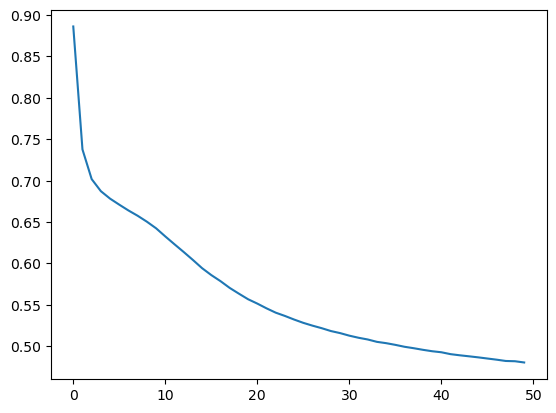

In [10]:
# plot the training and validation losses
plt.plot(history['train_losses'], label='Training Loss')
# plt.plot(history['valid_losses'], label='Validation Loss')

# Inference test set

Plot the actual and predicted values and calculate the correlation

In [15]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            targets = torch.expm1(targets)
            outputs = model(images)
            outputs = torch.expm1(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)


In [16]:
# load the best model
model = RetinaCNN()
model.load_state_dict(torch.load('../models/final_model_simple_3conv_exp.pth'))
model.cuda()

RetinaCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc): Linear(in_features=40000, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

In [17]:
predictions, targets = predict_loader(model, test_loader)

Batches: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


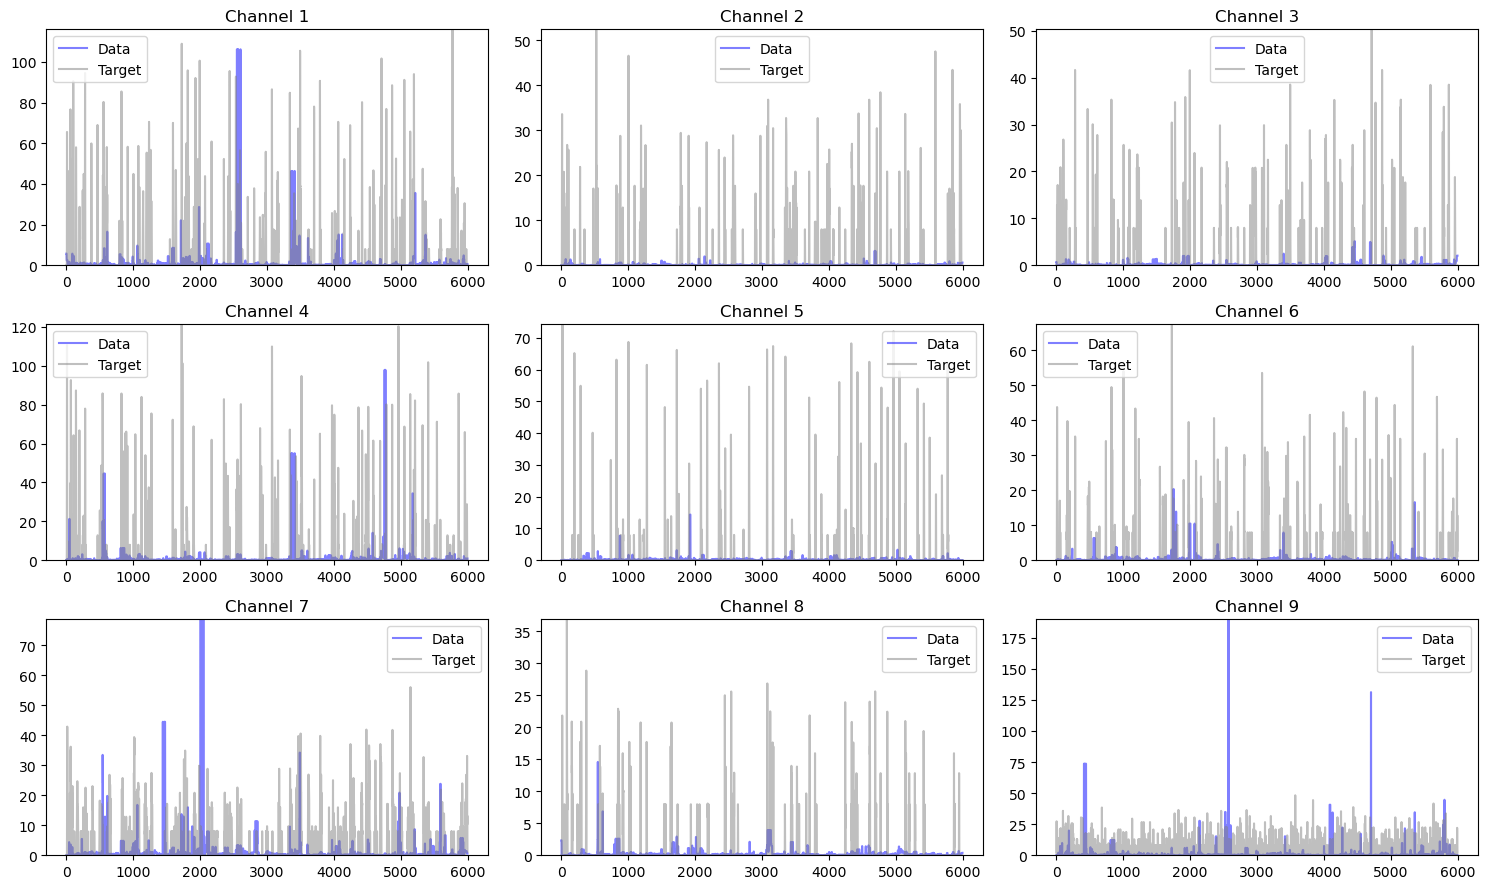

In [18]:
plot_time_series(np.transpose(predictions), np.transpose(targets))

In [32]:
max(np.transpose(predictions)[0])

3.4512012004852295